In [1]:
import numpy as np

newdataList1 = []
newdataList2 = []

#ファイルを開いて読む
for line in open('170118-1.txt', 'r'):
    
    #1行ずつデータを読む
    itemList = line[:-1].split('\t')
    
    
    dataList1 = list(itemList[2])
    dataList2 = list(itemList[3])
    
    newdataList1.append(dataList1)
    newdataList2.append(dataList2)

#不要な一行めのデータを削除、削除したデータを表示
newdataList1.pop(0)
newdataList2.pop(0)


p = np.array(newdataList1)
n = np.array(newdataList2)

P = p.astype(np.float64)
N = n.astype(np.float64)

In [2]:
#10%のミスマッチ
miss = np.array([ 0.97,  0.97,  0.96,  0.98,  0.93,  1.03,  1.02,  0.99])

In [3]:
out = P-N

In [4]:
#各スピーカ出力にミスマッチを加える
for i in range(0, 65535):
    out[i] = out[i] * miss

In [5]:
#各スピーカ駆動信号を加算
out8 = [[0 for i in range(1)] for j in range(65536)]
for i in range(0, 65535):
    out8[i] = out[i][0] + out[i][1] + out[i][2] + out[i][3] + out[i][4] + out[i][5] + out[i][6] + out[i][7]

In [6]:
#加算結果を8で割ってフルスケールを＋１～ー１にする
out8_1 = [[0 for i in range(1)] for j in range(65536)]
for i in range(0, 65535):
    out8_1[i] = out8[i]/8

In [7]:
#65536行1列の空の配列を作成
OUT = np.zeros((65536,1))

#空の配列にFPGA出力結果を入れていく
for i in range(0, 65535):
    OUT[i] = out8_1[i]

In [8]:
#古屋作成のFFT計算モジュール
#おまじない的な部分
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.fftpack import fft
import math

In [9]:
out = OUT  #FPGA出力結果を代入
N = len(out)
fs = 6144000 # サンプリング周波数(正規化したい場合は1)
osr = 128 # オーバーサンプリング比
fB = math.ceil(N/(2*osr)) # 帯域幅
suso = 20 #信号の裾野
offset = 300

In [10]:
window=np.hanning(N)       #hanning窓を作る
out=out
sim_n=fft(out.T*window)   #FFTを計算
simfft_norm = sim_n/(N/4) 
simfftdb_norm = 20*np.log10(abs(simfft_norm)).T # 絶対値を取ってdB換算

fre = np.arange(N)/N*fs # 周波数軸を正規化

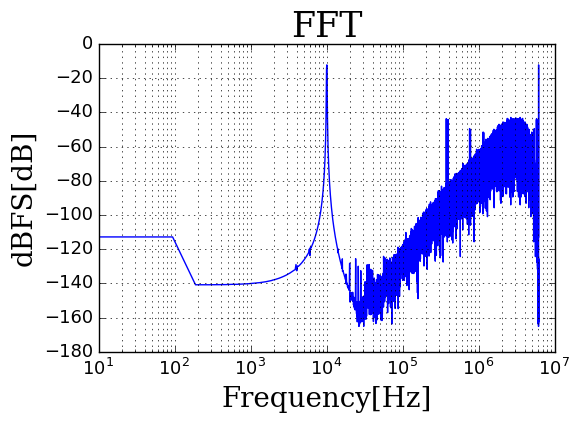

In [11]:
#FFTを描写
plt.xscale("log")
plt.grid(which="both")
plt.title("FFT", fontsize=25, fontname='serif')
plt.xlabel("Frequency[Hz]", fontsize=20, fontname='serif')
plt.ylabel("dBFS[dB]", fontsize=20, fontname='serif')
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.plot(fre,simfftdb_norm, color="blue")
plt.subplots_adjust(left=0.19, bottom=0.15, right=0.95, top=0.92, wspace=None, hspace=None)

In [12]:
bandfft=simfft_norm.T[0:fB] #FFTを帯域幅分だけ切り出す

In [13]:
#fin=np.argmax(bandfft)#帯域幅に存在する最大値のインデックスを入力中心周波数と定義
fin=math.floor(107/256*fB)
fin

107

In [14]:
# 入力中心周波数に裾野を加えた分が帯域幅を超えないよう処理
finmin = fin-suso if fin-suso > 0 else 0 
finmax = fin+suso if fin+suso < fB else fB
signal=bandfft[106:109] # 入力中心周波数に裾野を加えたものを入力信号と定義

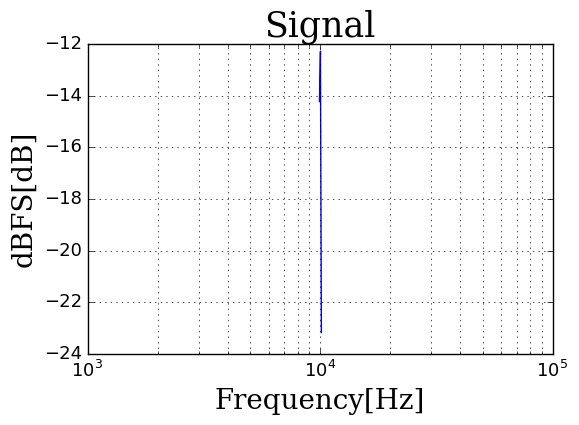

In [15]:
#信号成分のみFFTを描写
plt.xscale("log")
plt.grid(which="both")
plt.title("Signal", fontsize=25, fontname='serif')
plt.xlabel("Frequency[Hz]", fontsize=20, fontname='serif')
plt.ylabel("dBFS[dB]", fontsize=20, fontname='serif')
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.plot(fre[106:109],20*np.log10(abs(signal)), color="blue")

In [16]:
#信号成分の電力を計算
signalpower=np.linalg.norm(signal)
signalpower

0.31857717157707693

In [17]:
#noise=np.vstack((bandfft[5:87],bandfft[fin+suso:fB])) ##入力信号を抜いた分をノイズとする
noise1=bandfft[5:87] 

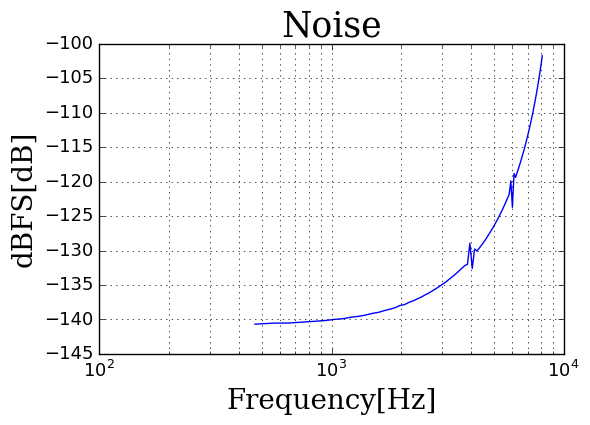

In [18]:
#雑音成分（低域側）のみFFTを描写
plt.xscale("log")
plt.grid(which="both")
plt.title("Noise", fontsize=25, fontname='serif')
plt.xlabel("Frequency[Hz]", fontsize=20, fontname='serif')
plt.ylabel("dBFS[dB]", fontsize=20, fontname='serif')
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

#plt.plot(20*np.log10(abs(noise)), color="blue")
plt.plot(fre[5:87],20*np.log10(abs(noise1)), color="blue")

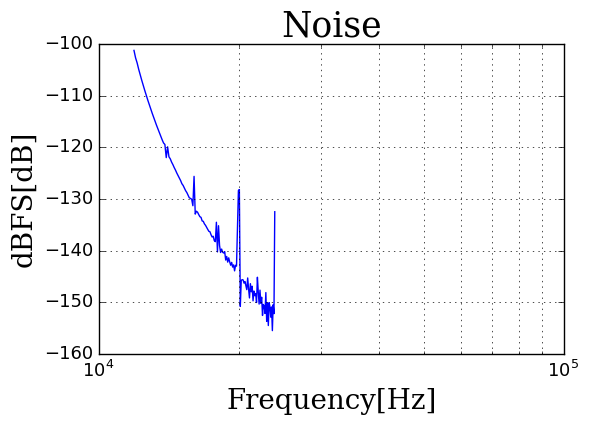

In [19]:
#雑音成分（高域側）のみFFTを描写
noise2=bandfft[127:256]
plt.xscale("log")
plt.grid(which="both")
plt.title("Noise", fontsize=25, fontname='serif')
plt.xlabel("Frequency[Hz]", fontsize=20, fontname='serif')
plt.ylabel("dBFS[dB]", fontsize=20, fontname='serif')
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.plot(fre[127:256],20*np.log10(abs(noise2)), color="blue")

In [20]:
#雑音成分の電力を計算
noisepower1=np.linalg.norm(noise1)#低域
noisepower2=np.linalg.norm(noise2)#高域
noisepower=noisepower1+noisepower2#低域＋高域
noisepower

3.6042498694217044e-05

In [21]:
#SNRを算出
snr =20*np.log10(signalpower/noisepower)
snr

78.927995215150489